In [1]:
import os
import json
import pandas as pd
import sentencepiece as spm
import wget
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchtext
from konlpy.tag import Mecab
from torchtext.data import Field, BucketIterator, TabularDataset, Dataset
import os
import tqdm

In [2]:
DATA_PATH = '/home/pjh0227/DeepLearning/MidasIT/PytorchStudy/nsmc/' # Data Path
tagger = Mecab()
USE_CUDA = torch.cuda.is_available()
device = 'cuda' # or 'cpu'

TEXT = Field(tokenize=tagger.morphs,lower=True,include_lengths=False,batch_first=True)
LABEL = Field(sequential=False,use_vocab=True,unk_token=None)

train_data, test_data = TabularDataset.splits(path=DATA_PATH,
 train='ratings_train.txt',
 test='ratings_test.txt',
 format='tsv', 
 skip_header=True, 
 fields=[('id',None),('text',TEXT),('label',LABEL)], 
 filter_pred = lambda x: True if len(x.text) > 1 else False)

TEXT.build_vocab(train_data,min_freq=2)
LABEL.build_vocab(train_data)

train_loader, test_loader = BucketIterator.splits((train_data,test_data),sort_key=lambda x:len(x.text), sort_within_batch=True,
 repeat=False,shuffle=True, batch_size=1,device=device)

max_enc_length = 20
enc_inputs = []
dec_inputs = []

for bat in train_loader:
    inputs, labels = bat.text, bat.label.float()
    
    if (inputs.size()[1]>max_enc_length): # skisp size > 50
        continue
    enc_inputs.append(inputs[0])
    dec_inputs.append(labels[0])

pad_enc_inputs = torch.nn.utils.rnn.pad_sequence(enc_inputs, batch_first=True, padding_value=0)
labels_inputs = torch.tensor(dec_inputs)#torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True, padding_value=10)
# labels_inputs = torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True, padding_value=10)

# dec_inputs = torch.tensor([2])
print("[Train set]")
print('encoder input size : ', pad_enc_inputs.size())
# print('decoder input size : ', dec_inputs.size())
print('labels size : ', labels_inputs.size())


## For Test Set Read
enc_inputs_test = []
dec_inputs_test = []
for bat in test_loader:
    inputs_test, labels_test = bat.text, bat.label.float()
#     print(inputs_test.size())
    if (inputs_test.size()[1]>max_enc_length): # skisp size > 50
        continue
    enc_inputs_test.append(inputs_test[0])
    dec_inputs_test.append(labels_test[0])

pad_enc_inputs_test = torch.nn.utils.rnn.pad_sequence(enc_inputs_test, batch_first=True, padding_value=0)
labels_inputs_test = torch.tensor(dec_inputs_test)#torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True, padding_value=10)
# labels_inputs = torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True, padding_value=10)

# dec_inputs = torch.tensor([2])
print("[Test set]")
print('encoder input size : ', pad_enc_inputs_test.size())
# print('decoder input size : ', dec_inputs.size())
print('labels size : ', labels_inputs_test.size())
print('Done!')

[Train set]
encoder input size :  torch.Size([104447, 20])
labels size :  torch.Size([104447])
[Test set]
encoder input size :  torch.Size([34674, 20])
labels size :  torch.Size([34674])
Done!


In [3]:
class Embedding(nn.Module):
    def __init__(self, n_vocab, d_model):
        super().__init__()
        self.embed = nn.Embedding(n_vocab, d_model)
    def forward(self,x):
        return self.embed(x)
    
# Sinusoid vector
def Get_Sinusoid_Table(seq_n, d_model):
    def cal_angle(position, i_hidden):
        return position / np.power(10000, 2 * (i_hidden // 2) / d_model)
    def get_pos_angle_vec(pos):
        return [cal_angle(pos, i_hidden) for i_hidden in range(d_model)]
    
    sinusoid_table = np.array([get_pos_angle_vec(i_seq) for i_seq in range(seq_n)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

# Add Sinusoid & Embedding
def Add_Positional_Embedding(inputs, Input_Embedding, d_model):
    seq_n = Input_Embedding.size()[1]
    pos_encoding = torch.FloatTensor(Get_Sinusoid_Table(seq_n, d_model)) # positional embedding vec
    nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True).to(device)
    
    positions = torch.arange(inputs.size(1), dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous().to(device)
    
    pos_mask = inputs.eq(0)
    positions.masked_fill_(pos_mask, 0)
    pos_embs = nn_pos(positions) # position embedding

    out = Input_Embedding + pos_embs
    return out

def GetMultiHeadMask(inputs, enc_input_QWi, enc_input_KWi): # GetEncoderMask
    if (len(enc_input_QWi.size())<4):
        print("Encoder QWi dim is not 4, (batch, seq, n_head, hidden/n_head)")
        return

    pad_mask = inputs.eq(0).unsqueeze(1).expand(enc_input_QWi.size(0), enc_input_QWi.size(1), enc_input_QWi.size(2))
    EncMask = pad_mask.unsqueeze(2).repeat(1, 1, enc_input_KWi.size()[2], 1)

    return EncMask

def GetMaskedMultiHeadMask(dec_inputs, dec_input_QWi, dec_input_KWi): # GetDecoderMask
    if (len(dec_input_QWi.size())<4):
        print("dec QWi dim is not 4, (batch, seq, n_head, hidden/n_head)")
        return
    np_tri_mask = np.triu(np.ones((dec_inputs.size()[0],dec_input_QWi.size()[1],dec_input_QWi.size()[2],dec_input_KWi.size()[2])),k=1).astype('uint8')
    tri_mask = torch.from_numpy(np_tri_mask).to(device)
    pad_mask = dec_inputs.eq(0).unsqueeze(1).expand(dec_input_QWi.size(0), dec_input_QWi.size(1), dec_input_KWi.size(2))
    pad_mask = pad_mask.unsqueeze(2).repeat(1, 1, dec_input_QWi.size()[2], 1)
    DecMask = torch.add(tri_mask>0, pad_mask==True)
    return DecMask

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, Q, K, V, attn_mask):
        score_mat = torch.matmul(Q,K.transpose(-1,-2)).mul_(1/Q.size()[-1]**0.5)
        score_mat_attn = score_mat.masked_fill_(attn_mask, -1e9)
        score_mat_prob = nn.Softmax(dim=-1)(score_mat_attn)
        head_i = torch.matmul(score_mat_prob, V)
        return head_i
    
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, dropout = 0.1):
        super().__init__()
        #self.d_k = d_model // n_head        
        # 512 Linear -> separate 64 * n_head
        self.W_Q_linear = nn.Linear(d_model, d_model) 
        self.W_K_linear = nn.Linear(d_model, d_model)
        self.W_V_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.W_O_linear = nn.Linear(d_model, d_model)
        
    def forward(self, enc_inputs, dec_inputs, Q, K, V, n_head, Encoder=True, MaskedMultiHead=False):
        batch_size = Q.size()[0]
        
        # perform linear operation and split into h heads        
        QWi_Q = self.W_Q_linear(Q).view(batch_size, -1, n_head, int(d_model/n_head)).transpose(1,2).to(device)
        KWi_K = self.W_K_linear(K).view(batch_size, -1, n_head, int(d_model/n_head)).transpose(1,2).to(device)
        VWi_V = self.W_V_linear(V).view(batch_size, -1, n_head, int(d_model/n_head)).transpose(1,2).to(device)
        
        if Encoder == True:
            EncMask = GetMultiHeadMask(enc_inputs, QWi_Q, KWi_K)
            Mask = EncMask
        else: # make Decoder mask
            if MaskedMultiHead == False:
                DecMask = GetMultiHeadMask(enc_inputs, KWi_K, QWi_Q)
            else:
                DecMask = GetMaskedMultiHeadMask(dec_inputs, QWi_Q, KWi_K)
            Mask = DecMask
        # Scaled dot product attention -> head_i
        head_i = ScaledDotProductAttention()(QWi_Q, KWi_K, VWi_V, Mask)
        
        # concatenat heads
        concat = head_i.transpose(1, 2).contiguous().view(batch_size, QWi_Q.size()[2], d_model)
        # concat * W_O
        output = self.W_O_linear(concat)
    
        return output
    
class Normalization(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()    
        self.size = d_model
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm
    
class FeedForward(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_model*4)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_model*4, d_model)
    def forward(self, input_tensor):
        x = self.dropout(F.relu(self.linear1(input_tensor)))
        out_tensor = self.linear2(x)
        return out_tensor
    
class Encoder(nn.Module):
    def __init__(self, d_model, n_head, n_vocab, N=6, dropout=0.1):
        super().__init__()
        self.embed = Embedding(n_vocab, d_model)
        self.MultiHeadAtt = MultiHeadAttention(d_model)
        self.Norm = Normalization(d_model)
        self.ff = FeedForward(d_model)
        self.N = N
        self.d_model = d_model
        self.n_head = n_head
    def forward(self, word):
        emb_word = self.embed(word)
        pos_emb_word = Add_Positional_Embedding(word, emb_word, self.d_model)
        x = pos_emb_word
        for i in range(self.N): # N-times ittr
            # Sublayer1
            x = self.MultiHeadAtt(word, word, x, x, x, self.n_head, Encoder=True, MaskedMultiHead=False) # Q K V, # Multi head att
            out_sublayer1 = x + self.Norm(x) # Add & Norm
            x = out_sublayer1
            
            # Sublayer2
            x = self.ff(x)
            out_sublayer2 = out_sublayer1 + self.Norm(x) # Add & Norm
            x = out_sublayer2
        return x
    
class Decoder(nn.Module):
    def __init__(self, d_model, n_head, n_vocab, N=6, dropout=0.1):
        super().__init__()
        self.embed = Embedding(n_vocab, d_model)
        self.MultiHeadAtt = MultiHeadAttention(d_model)
        self.Norm = Normalization(d_model)
        self.ff = FeedForward(d_model)
        self.N = N
        self.d_model = d_model
        self.n_head = n_head
    def forward(self, dec_word, enc_out, enc_word):
        word = dec_word
        emb_word = self.embed(word)
        pos_emb_word = Add_Positional_Embedding(word, emb_word, self.d_model)
        x = pos_emb_word
        for i in range(self.N): # N-times ittr
            # Sublayer1
            x = self.MultiHeadAtt(dec_word, dec_word, x, x, x, self.n_head, Encoder=False, MaskedMultiHead=True) # Masked Multi Head Att
            out_sublayer1 = x + self.Norm(x) # Add & Norm
            
            # Sublayer2
            x = self.MultiHeadAtt(enc_word, dec_word, x, enc_out, enc_out, self.n_head, Encoder=False, MaskedMultiHead=False) # Q K V, # Multi head att
            out_sublayer2 = x + self.Norm(x) # Add & Norm
            x = out_sublayer2
            
            # Sublayer3
            x = self.ff(x)
            out_sublayer3 = out_sublayer2 + self.Norm(x) # Add & Norm
            x = out_sublayer3
#             print(x)
        return x
    
# Final Class
class Transformer(nn.Module):
    def __init__(self, d_model, n_head, enc_n_vocab, dec_n_vocab, N=6, dropout=0.1):
        super().__init__()
        self.encoder = Encoder(d_model, n_head, enc_n_vocab, N)
        self.decoder = Decoder(d_model, n_head, enc_n_vocab, N)#dec_n_vocab, N)
        self.out = nn.Linear(d_model, dec_n_vocab) # 512 -> n_vocab=2
    def forward(self, enc_word, dec_word):
        enc_out = self.encoder(enc_word)
        dec_out = self.decoder(dec_word, enc_out, enc_word)
        dec_out_l = self.out(dec_out)
        out = F.softmax(dec_out_l, dim=-1)

        return out.float()


In [4]:
# Model Define
d_model = 32 # hidden size
LR=0.001
n_vocab = pad_enc_inputs.max().cpu().data.numpy().max() + 1

model = Transformer(d_model=d_model, n_head=8, enc_n_vocab=n_vocab, dec_n_vocab=2, N=3)
model = model.to(device)

loss_function = nn.CrossEntropyLoss() #BCELoss() # 
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#optim.SGD(model.parameters(), lr=LR)

# model.train()

print("Model define Done!")

Model define Done!


Epoch # 1
Loss[Blue] :  tensor(0.5866, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.7030, device='cuda:0')


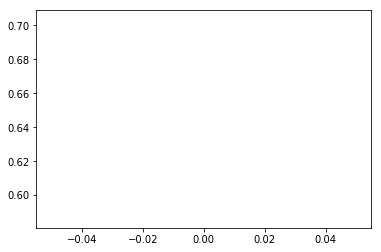

Epoch # 2
Loss[Blue] :  tensor(0.5345, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.7620, device='cuda:0')


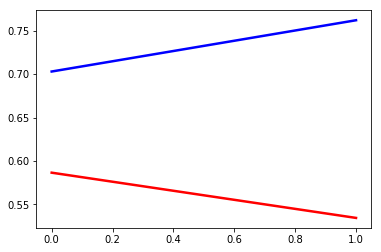

Epoch # 3
Loss[Blue] :  tensor(0.5074, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8020, device='cuda:0')


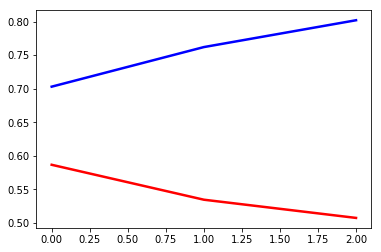

Epoch # 4
Loss[Blue] :  tensor(0.4960, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8080, device='cuda:0')


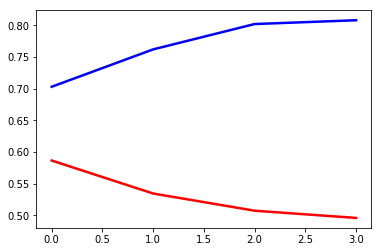

Epoch # 5
Loss[Blue] :  tensor(0.4776, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8320, device='cuda:0')


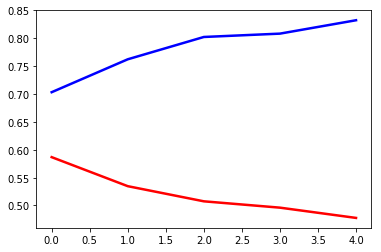

Epoch # 6
Loss[Blue] :  tensor(0.4693, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8370, device='cuda:0')


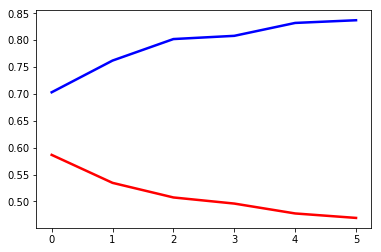

Epoch # 7
Loss[Blue] :  tensor(0.4573, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8570, device='cuda:0')


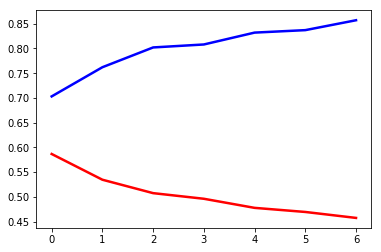

Epoch # 8
Loss[Blue] :  tensor(0.4490, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8590, device='cuda:0')


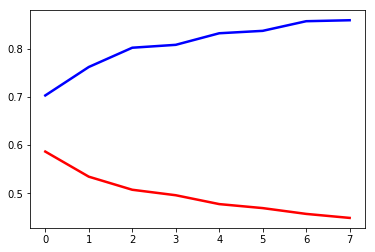

Epoch # 9
Loss[Blue] :  tensor(0.4488, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8610, device='cuda:0')


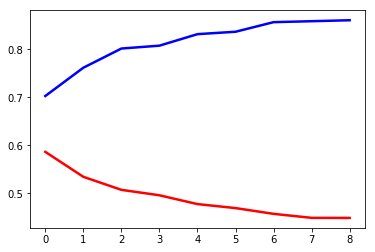

Epoch # 10
Loss[Blue] :  tensor(0.4403, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8760, device='cuda:0')


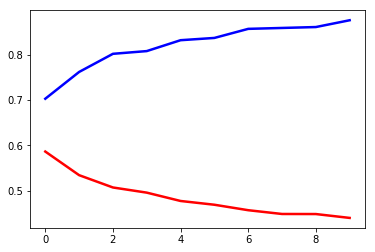

Epoch # 11
Loss[Blue] :  tensor(0.4412, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8710, device='cuda:0')


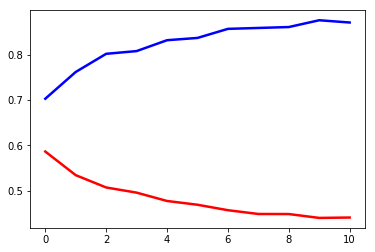

Epoch # 12
Loss[Blue] :  tensor(0.4411, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8710, device='cuda:0')


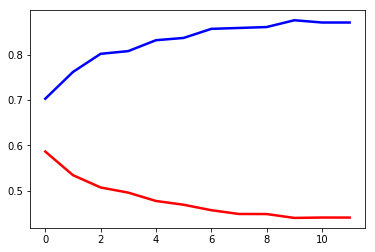

Epoch # 13
Loss[Blue] :  tensor(0.4334, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8800, device='cuda:0')


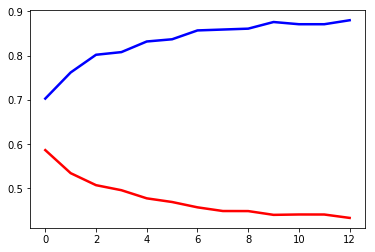

Epoch # 14
Loss[Blue] :  tensor(0.4238, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8890, device='cuda:0')


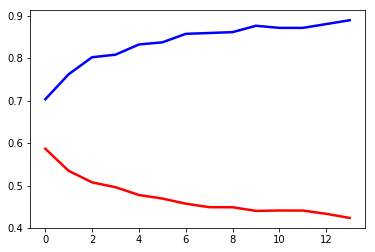

Epoch # 15
Loss[Blue] :  tensor(0.4287, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8840, device='cuda:0')


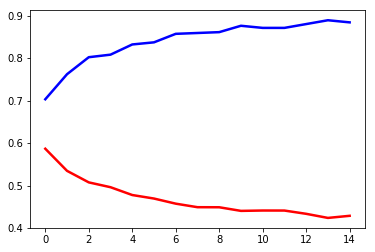

Epoch # 16
Loss[Blue] :  tensor(0.4294, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8850, device='cuda:0')


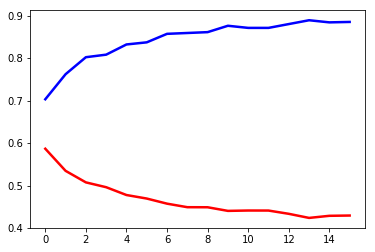

Epoch # 17
Loss[Blue] :  tensor(0.4402, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8690, device='cuda:0')


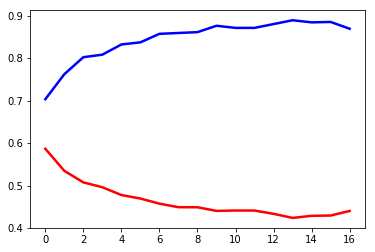

Epoch # 18
Loss[Blue] :  tensor(0.4237, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8890, device='cuda:0')


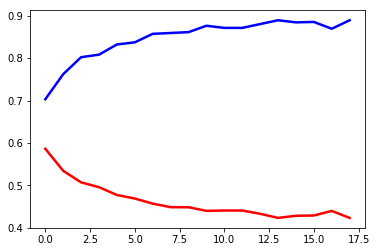

Epoch # 19
Loss[Blue] :  tensor(0.4278, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8820, device='cuda:0')


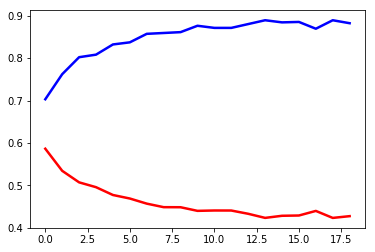

Epoch # 20
Loss[Blue] :  tensor(0.4146, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8980, device='cuda:0')


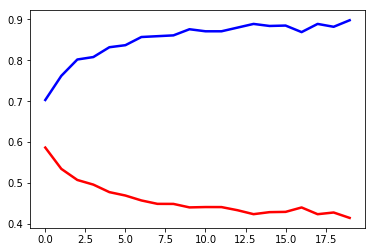

Epoch # 21
Loss[Blue] :  tensor(0.4125, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8990, device='cuda:0')


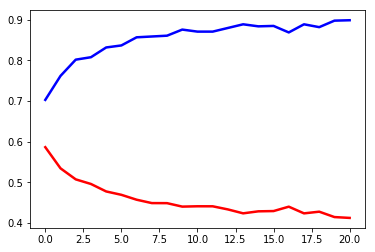

Epoch # 22
Loss[Blue] :  tensor(0.4143, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8980, device='cuda:0')


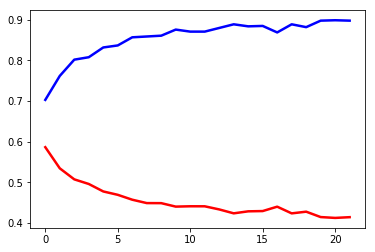

Epoch # 23
Loss[Blue] :  tensor(0.4144, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8990, device='cuda:0')


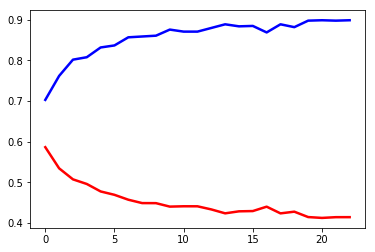

Epoch # 24
Loss[Blue] :  tensor(0.4130, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.9000, device='cuda:0')


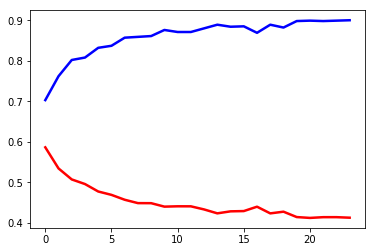

Epoch # 25
Loss[Blue] :  tensor(0.4116, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.9000, device='cuda:0')


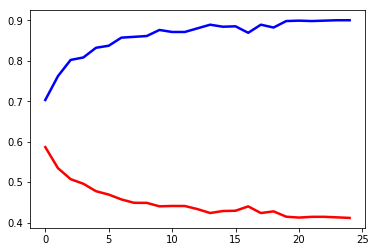

Epoch # 26
Loss[Blue] :  tensor(0.4108, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.9010, device='cuda:0')


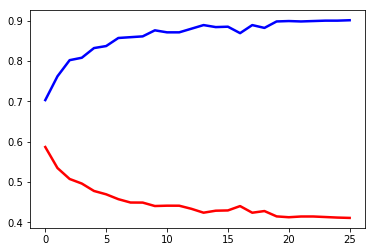

Epoch # 27
Loss[Blue] :  tensor(0.4202, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8910, device='cuda:0')


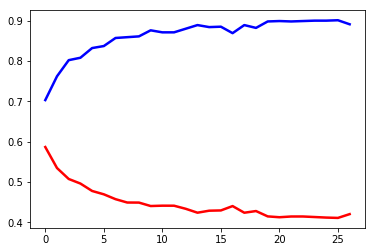

Epoch # 28
Loss[Blue] :  tensor(0.4086, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.9060, device='cuda:0')


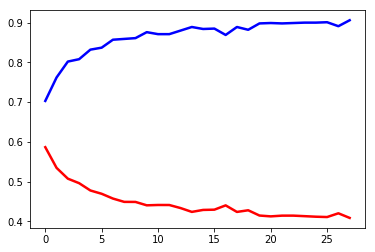

Epoch # 29
Loss[Blue] :  tensor(0.4137, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8990, device='cuda:0')


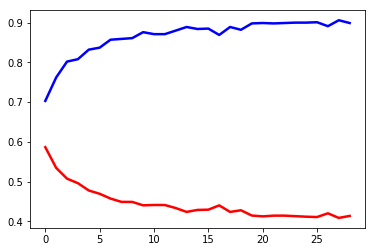

Epoch # 30
Loss[Blue] :  tensor(0.4244, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8870, device='cuda:0')


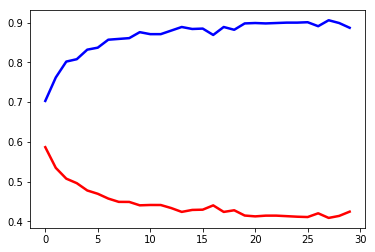

Epoch # 31
Loss[Blue] :  tensor(0.4164, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8960, device='cuda:0')


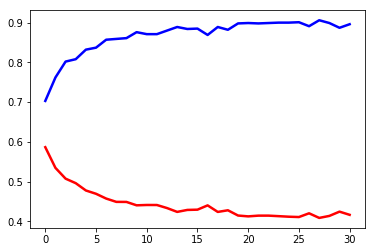

Epoch # 32
Loss[Blue] :  tensor(0.4163, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8970, device='cuda:0')


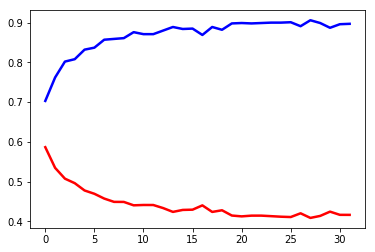

Epoch # 33
Loss[Blue] :  tensor(0.4151, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8980, device='cuda:0')


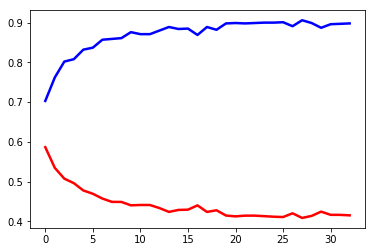

Epoch # 34
Loss[Blue] :  tensor(0.4090, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.9050, device='cuda:0')


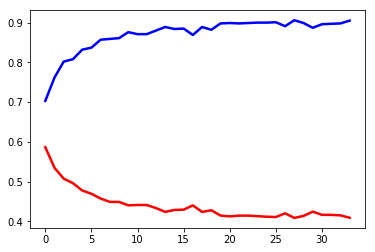

Epoch # 35
Loss[Blue] :  tensor(0.4191, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8930, device='cuda:0')


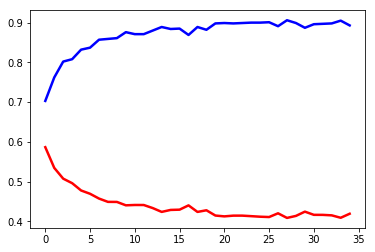

Epoch # 36
Loss[Blue] :  tensor(0.4153, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.8970, device='cuda:0')


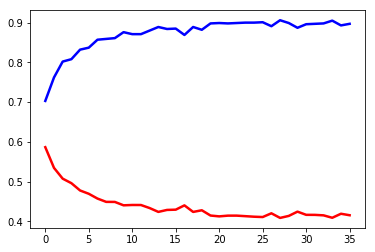

Epoch # 37
Loss[Blue] :  tensor(0.4125, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.9010, device='cuda:0')


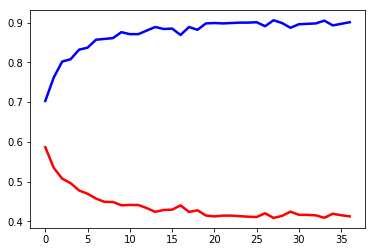

Epoch # 38
Loss[Blue] :  tensor(0.4098, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.9020, device='cuda:0')


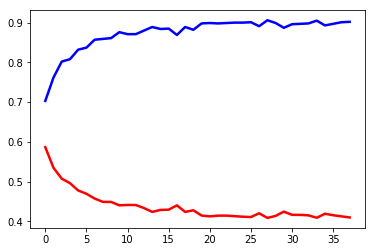

Epoch # 39
Loss[Blue] :  tensor(0.4107, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.9000, device='cuda:0')


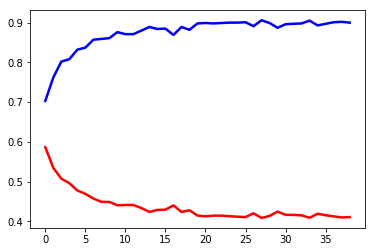

Epoch # 40
Loss[Blue] :  tensor(0.4076, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.9070, device='cuda:0')


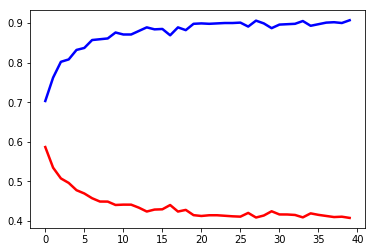

Epoch # 41
Loss[Blue] :  tensor(0.4095, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.9040, device='cuda:0')


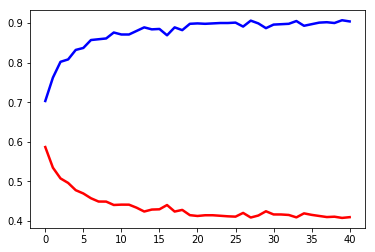

Epoch # 42
Loss[Blue] :  tensor(0.4002, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.9120, device='cuda:0')


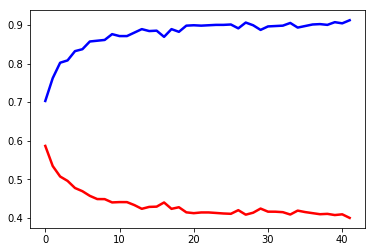

Epoch # 43
Loss[Blue] :  tensor(0.4021, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.9100, device='cuda:0')


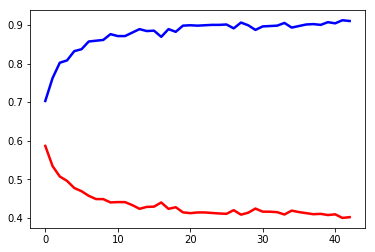

Epoch # 44
Loss[Blue] :  tensor(0.3999, device='cuda:0', grad_fn=<NllLossBackward>)
Score[Red] :  tensor(0.9130, device='cuda:0')


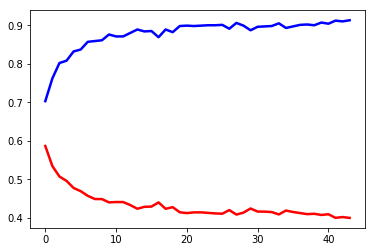

Epoch # 45


KeyboardInterrupt: 

In [5]:
# Train Test...

epoch_n = 0
# step = 0
batch_size = 1000

dec_inputs = []
for i in range(batch_size):
    dec_inputs.append([2])
torch_dec_inputs = torch.tensor(dec_inputs).to(device)

loss_vec = []
score_vec = []

model.train()
while(True):
    epoch_n+=1
    print ("Epoch #",epoch_n)
    for i in range(0,pad_enc_inputs.size()[0]-batch_size, batch_size):


        model.zero_grad()

        inputs = pad_enc_inputs[i:i+batch_size].to(device)
        labels = labels_inputs[i:i+batch_size].to(device).long()

        tag_scores = model(inputs, torch_dec_inputs)
        loss = loss_function(tag_scores[:,0], labels)
        loss.backward()
        optimizer.step()
    print("Loss[Blue] : ",loss)
    loss_vec.append(loss)
    

    # Check score
    results = tag_scores[:,:,1]>0.5
    A = results[:,0]==labels[:]
    tensor_test_score = A.sum().float() / labels.size()[0]
    #test_score = tensor_test_score.cpu().data
    score_vec.append(tensor_test_score)
    print("Score[Red] : ", tensor_test_score)
    plt.plot(score_vec, color = 'blue', linewidth = 2.5, linestyle = "-")

    plt.plot(loss_vec, color = 'red', linewidth = 2.5, linestyle = "-")
    plt.show()
    
    
    

In [6]:
# Check testset score
model.eval()
sum_score_test = []
score_vec_test = []
for i in range(0,pad_enc_inputs_test.size()[0]-batch_size, batch_size):
    inputs_test = pad_enc_inputs_test[i:i+batch_size].to(device)
    labels_test = labels_inputs_test[i:i+batch_size].to(device).long()
    tag_scores_test = model(inputs_test, torch_dec_inputs)

    results_test = tag_scores_test[:,:,1]>0.5
    A = results_test[:,0]==labels_test[:]
    tensor_test_score = A.sum().float() / labels_test.size()[0]
    score_vec_test.append(tensor_test_score.cpu().data.numpy()/1)
    
print("Testset Mean Score : ", sum(score_vec_test) / len(score_vec_test))

Testset Mean Score :  0.824000036015
